In [78]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from scipy.sparse import hstack

In [79]:
# Function to train and evaluate a model
def train_and_evaluate(X_train, X_test, y_train, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return rmse, r2, y_pred

In [80]:
data.shape

(5638, 14)

In [81]:
# Load the dataset
data = pd.read_csv('/Users/chloedaul/Desktop/epfl/MA3/ADA/projet/ada-2024-project-padawans/features_df.csv')


# Preprocessing: Select relevant columns and target variable
features = ['tags', 'Movie genres', 'Movie languages', 'Movie countries', 'Movie runtime', 'IMDB Box-office', 'numVotes']
target = 'averageRating'

# Drop rows with missing values in features or target
data_cleaned = data[features + [target]].dropna()

# Define textual and numerical features
textual_features = ['tags', 'Movie genres', 'Movie languages', 'Movie countries']
numerical_features = ['Movie runtime', 'IMDB Box-office', 'numVotes']

# Extract numerical features
numerical_features_data = data_cleaned[numerical_features].fillna(0).values

# Define target variable
y = data_cleaned[target]

In [82]:
data_cleaned.shape

(5638, 8)

For the analysis, we will test three different models for linear regression. The first model will use only numerical features, the second will use only categorical features, and the third will combine both numerical and categorical features. This approach will allow us to determine which model performs best and identify which features have the most significant impact on the average ratings.

In [83]:
# 1. Numerical Features Only
# Standardize numerical features to ensure equal weighting
scaler = StandardScaler()
numerical_features_data_scaled = scaler.fit_transform(numerical_features_data)

# Train model
X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(numerical_features_data_scaled, y, test_size=0.2, random_state=42)
rmse_num, r2_num, y_pred_num = train_and_evaluate(X_train_num, X_test_num, y_train_num, y_test_num)

The dataset includes text features like tags, genres, and languages, which need to be turned into numbers for regression models. TF-IDF is used to measure how important a word is, while limiting each feature to 50 terms to keep the data manageable. Even with this limit, combining all text features can still create a large dataset, so PCA is used to shrink it further while keeping 95% of the important information. This makes the data simpler, avoids duplication, and ensures the model can use the most meaningful patterns.

In [84]:
# 2. Categorical Features Only (TF-IDF reduced with PCA)
# Initialize TF-IDF vectorizers for textual features
vectorizers = {feature: TfidfVectorizer(max_features=50) for feature in textual_features}

# Apply TF-IDF transformation to each textual column
tfidf_transformed = {feature: vectorizers[feature].fit_transform(data_cleaned[feature].fillna('')) for feature in textual_features}

# Combine all TF-IDF vectors into a single sparse matrix
tfidf_combined = hstack(list(tfidf_transformed.values()))

# Apply PCA to TF-IDF features
pca = PCA(n_components=0.95, random_state=42)  # Retain 95% of variance
tfidf_reduced = pca.fit_transform(tfidf_combined.toarray())

# Train model
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(tfidf_reduced, y, test_size=0.2, random_state=42)
rmse_cat, r2_cat, y_pred_cat = train_and_evaluate(X_train_cat, X_test_cat, y_train_cat, y_test_cat)

In [85]:
# 3. Combined Features
# Combine PCA-reduced TF-IDF features with scaled numerical features
X_combined_reduced = np.hstack([tfidf_reduced, numerical_features_data_scaled])

# Train model
X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(X_combined_reduced, y, test_size=0.2, random_state=42)
rmse_comb, r2_comb, y_pred_comb = train_and_evaluate(X_train_comb, X_test_comb, y_train_comb, y_test_comb)


In [86]:
# Compare the results
comparison_results = pd.DataFrame({
    'Feature Set': ['Numerical Only', 'Categorical Only', 'Combined'],
    'RMSE': [rmse_num, rmse_cat, rmse_comb],
    'R²': [r2_num, r2_cat, r2_comb]
})

print(comparison_results)

        Feature Set      RMSE        R²
0    Numerical Only  0.975319  0.130247
1  Categorical Only  0.897272  0.263876
2          Combined  0.870385  0.307331


From this results, we see that categorical features are better at predicting movie ratings, explaining 26% of the variance, while numerical features explain only 13%. Combining both gives the best results, explaining 31% of the variance and having the lowest error. This shows that using both types of features together works best.

To display the most important features in each PCA component, we need to analyze the PCA loadings. These loadings represent how much each original feature contributes to each PCA component.

In [87]:
# Get PCA loadings (how much each original TF-IDF feature contributes to each PCA component)
pca_loadings = pca.components_

# Combine all TF-IDF feature names
tfidf_feature_names = (
    list(vectorizers['tags'].get_feature_names_out()) +
    list(vectorizers['Movie genres'].get_feature_names_out()) +
    list(vectorizers['Movie languages'].get_feature_names_out()) +
    list(vectorizers['Movie countries'].get_feature_names_out())
)

# Analyze the top contributing features for the first few PCA components
num_components_to_inspect = 3  # Inspect the first 3 components
top_contributions = {}

for i in range(num_components_to_inspect):
    component_loadings = pca_loadings[i]
    # Get the indices of the top features contributing to this component
    top_indices = component_loadings.argsort()[-10:][::-1]
    top_features = [(tfidf_feature_names[j], component_loadings[j]) for j in top_indices]
    top_contributions[f"PCA Component {i+1}"] = top_features

top_contributions


{'PCA Component 1': [('kingdom', 0.18873965909149007),
  ('india', 0.14208593200154016),
  ('world', 0.14063545851632323),
  ('cinema', 0.13871130784152674),
  ('hindi', 0.10493313421619967),
  ('france', 0.0959096219769524),
  ('french', 0.09278667889593446),
  ('drama', 0.08493182372264775),
  ('germany', 0.059008461699038894),
  ('italy', 0.0535685622497521)],
 'PCA Component 2': [('romantic', 0.39312939583809664),
  ('comedy', 0.3175814692259126),
  ('romance', 0.1708458509517985),
  ('romantic', 0.16554161544238838),
  ('film', 0.14536597214746355),
  ('drama', 0.13748816784828674),
  ('musical', 0.08868538708473968),
  ('comedy', 0.08309993287061934),
  ('family', 0.07596063361109638),
  ('fantasy', 0.06803748063738307)],
 'PCA Component 3': [('kingdom', 0.598849662854257),
  ('english', 0.47117920528013035),
  ('language', 0.2928945782944815),
  ('drama', 0.11225845078792114),
  ('romantic', 0.10335843077975528),
  ('comedy', 0.08189440266832236),
  ('united', 0.0793977469449793

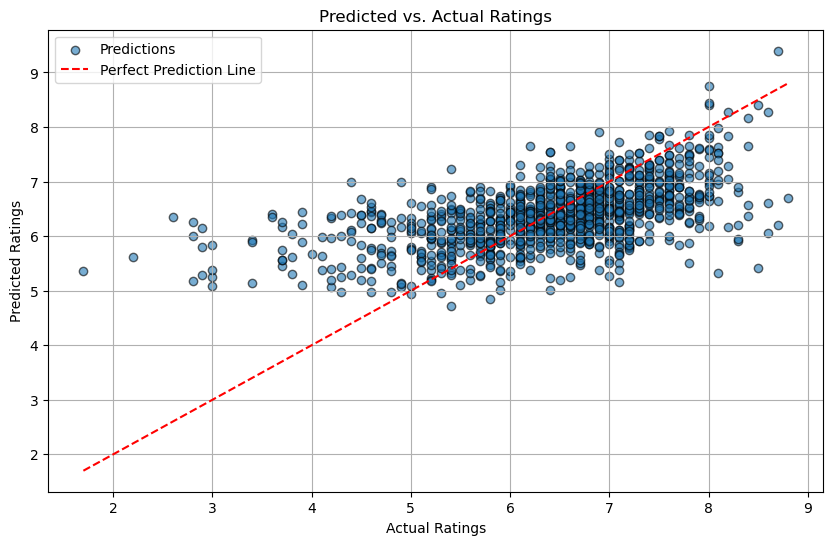

In [88]:
# Predicted vs. Actual Ratings
plt.figure(figsize=(10, 6))
plt.scatter(y_test_comb, y_pred_comb, alpha=0.6, edgecolor='k', label='Predictions')
plt.plot([min(y_test_comb), max(y_test_comb)], [min(y_test_comb), max(y_test_comb)], 
         color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predicted vs. Actual Ratings')
plt.legend()
plt.grid()
plt.show()

This scatter plot shows the relationship between the model's predicted ratings and the actual ratings. The red dashed line represents perfect predictions where the predicted and actual ratings are equal. Most predictions cluster near this line, especially in the middle range of ratings (5 to 7). However, the spread increases at the extremes, indicating that the model struggles to predict very high or very low ratings accurately. This suggests that while the model performs well for average-rated movies, additional features or non-linear modeling may be needed to handle edge cases.

The model shows some bias because movie ratings follow a binomial-like distribution, with most ratings concentrated in the middle range rather than the extremes. This imbalance means the model performs better for average ratings but struggles with very high or very low ratings due to fewer examples in these ranges. Addressing this may require techniques like weighting, oversampling the extremes, or using a non-linear model to better capture the nuances.

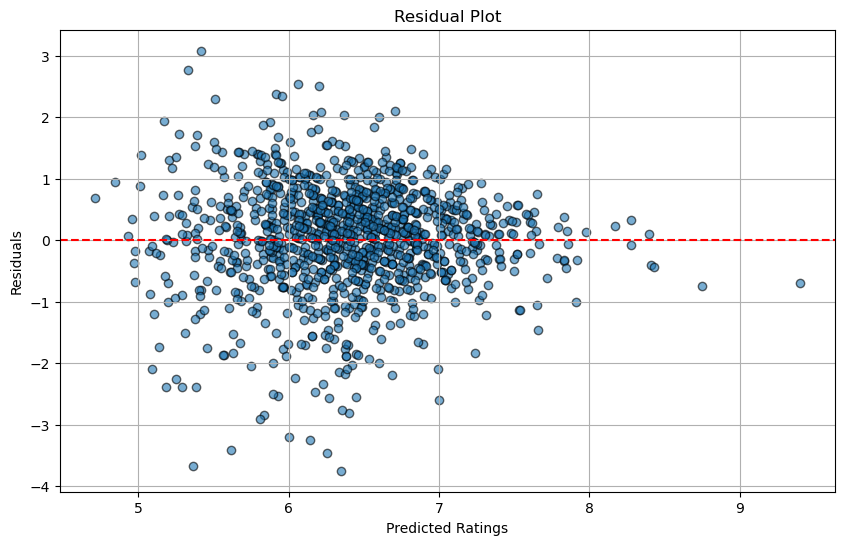

In [89]:
# Residual Plot
residuals_comb = y_test_comb - y_pred_comb
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_comb, residuals_comb, alpha=0.6, edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Ratings')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid()
plt.show()

The residual plot visualizes the differences between actual and predicted ratings (residuals) plotted against the predicted ratings. Ideally, residuals should be randomly scattered around the zero-error line (red dashed line). Here, the residuals are mostly centered around zero, indicating no strong systematic bias in the predictions. However, there is some spread, particularly at higher predicted ratings, suggesting the model's performance weakens for certain types of movies. This randomness implies the model captures the general structure of the data, but improvements can be made to reduce prediction errors.

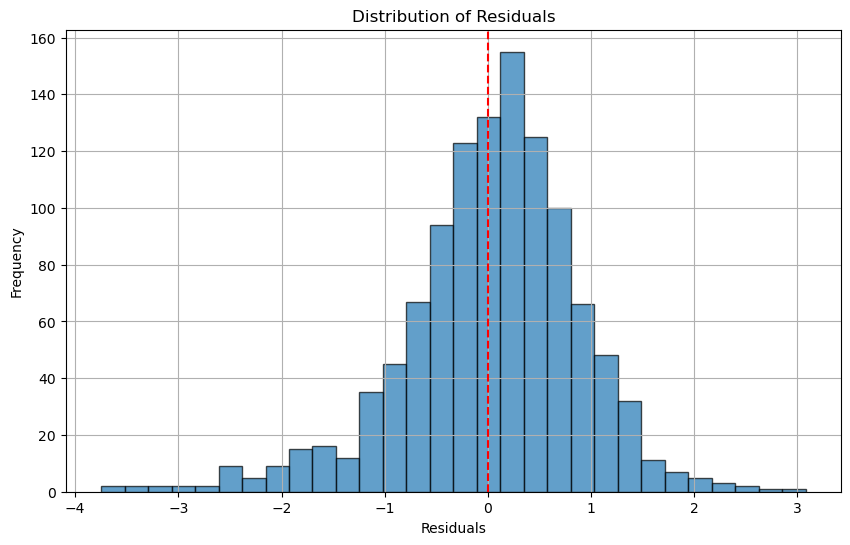

In [90]:
# Error Distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals_comb, bins=30, alpha=0.7, edgecolor='k')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid()
plt.show()


The histogram shows the frequency distribution of residuals, with a red dashed line at zero representing perfect predictions. The residuals are symmetrically distributed and centered around zero, which is a good sign for a regression model. Most residuals fall within the range of -2 to +2, indicating that the model generally makes accurate predictions. However, the presence of outliers in the tails suggests there are a few movies for which the model struggles to predict ratings accurately. These outliers may point to missing features or complexities not captured by the model.

In [95]:
from scipy.stats import ttest_1samp

# Number of shuffling iterations
n_iterations = 100

# Store RMSE and R² for shuffled models
rmse_shuffled_list = []
r2_shuffled_list = []

# Perform multiple shufflings and evaluations
for _ in range(n_iterations):
    X_combined_shuffled = X_combined_reduced.copy()
    np.random.shuffle(X_combined_shuffled)
    
    X_train_shuff, X_test_shuff, y_train_shuff, y_test_shuff = train_test_split(
        X_combined_shuffled, y, test_size=0.2, random_state=42
    )
    
    rmse_shuff, r2_shuff, _ = train_and_evaluate(X_train_shuff, X_test_shuff, y_train_shuff, y_test_shuff)
    rmse_shuffled_list.append(rmse_shuff)
    r2_shuffled_list.append(r2_shuff)

# Compute differences in performance metrics (Combined Model - Shuffled Models)
rmse_diff = np.array(rmse_shuffled_list) - rmse_comb
r2_diff = np.array(r2_shuffled_list) - r2_comb

# Perform t-tests for RMSE and R² differences
t_test_rmse = ttest_1samp(rmse_diff, 0)
t_test_r2 = ttest_1samp(r2_diff, 0)

# Summarize results
shuffled_results_summary = pd.DataFrame({
    'Metric': ['RMSE', 'R²'],
    'Combined Model': [rmse_comb, r2_comb],
    'Random Model (Mean)': [np.mean(rmse_shuffled_list), np.mean(r2_shuffled_list)],
    'Mean Difference (Combined - Random)': [np.mean(rmse_diff), np.mean(r2_diff)],
    'p-value': [t_test_rmse.pvalue, t_test_r2.pvalue]
})

print("Shuffled Model Performance with Statistical Significance", shuffled_results_summary)


Shuffled Model Performance with Statistical Significance   Metric  Combined Model  Random Model (Mean)  \
0   RMSE        0.870385             1.060058   
1     R²        0.307331            -0.027476   

   Mean Difference (Combined - Random)        p-value  
0                             0.189673  3.086983e-158  
1                            -0.334808  3.221313e-154  


The combined model is significantly better than the random model in both RMSE and $R^2$, with extremely low p-values highlighting the robustness and consistency of this difference. This validates that the combined model effectively captures meaningful relationships in the dataset, while the random model's poor performance emphasizes the importance of well-structured features.

The extremely low p-values can be attributed to the following:
   - _Large Sample Size_ : With a sufficiently large dataset, even small differences between models can become statistically significant because the test has more power to detect true effects.

   - _High Consistency Across Shuffle_ : If the combined model consistently outperforms the random model across all 100 iterations, the variability in the random model's performance is very low. This stability reduces the denominator of the t-statistic, amplifying the test statistic and resulting in extremely low p-values.

   - _Strong Model-Data Relationship_ : The combined model leverages meaningful features, while the random model lacks any inherent relationship between features and target. This strong contrast further accentuates the statistical significance.